In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
%matplotlib notebook

In [3]:
camera = cv2.VideoCapture(0)

def grab_frame():
    ret, frame = camera.read()
    return frame

In [4]:
face_cascade = cv2.CascadeClassifier("data/haarcascades/haarcascade_frontalface_default.xml")

In [5]:
import openvino
import ngraph as ng
import numpy as np
from openvino.inference_engine import IECore

In [6]:
model_xml = "age-gender-recognition-retail-0013\\FP32\\age-gender-recognition-retail-0013.xml"
model_bin = "age-gender-recognition-retail-0013\\FP32\\age-gender-recognition-retail-0013.bin"

C:\Users\mkowalski\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
ie = IECore()
net = ie.read_network(model = model_xml, weights = model_bin)
exec_net = ie.load_network(network=net, device_name="CPU")

In [8]:
nn, nc, nh, nw = net.input_info["data"].input_data.shape

<IPython.core.display.Javascript object>


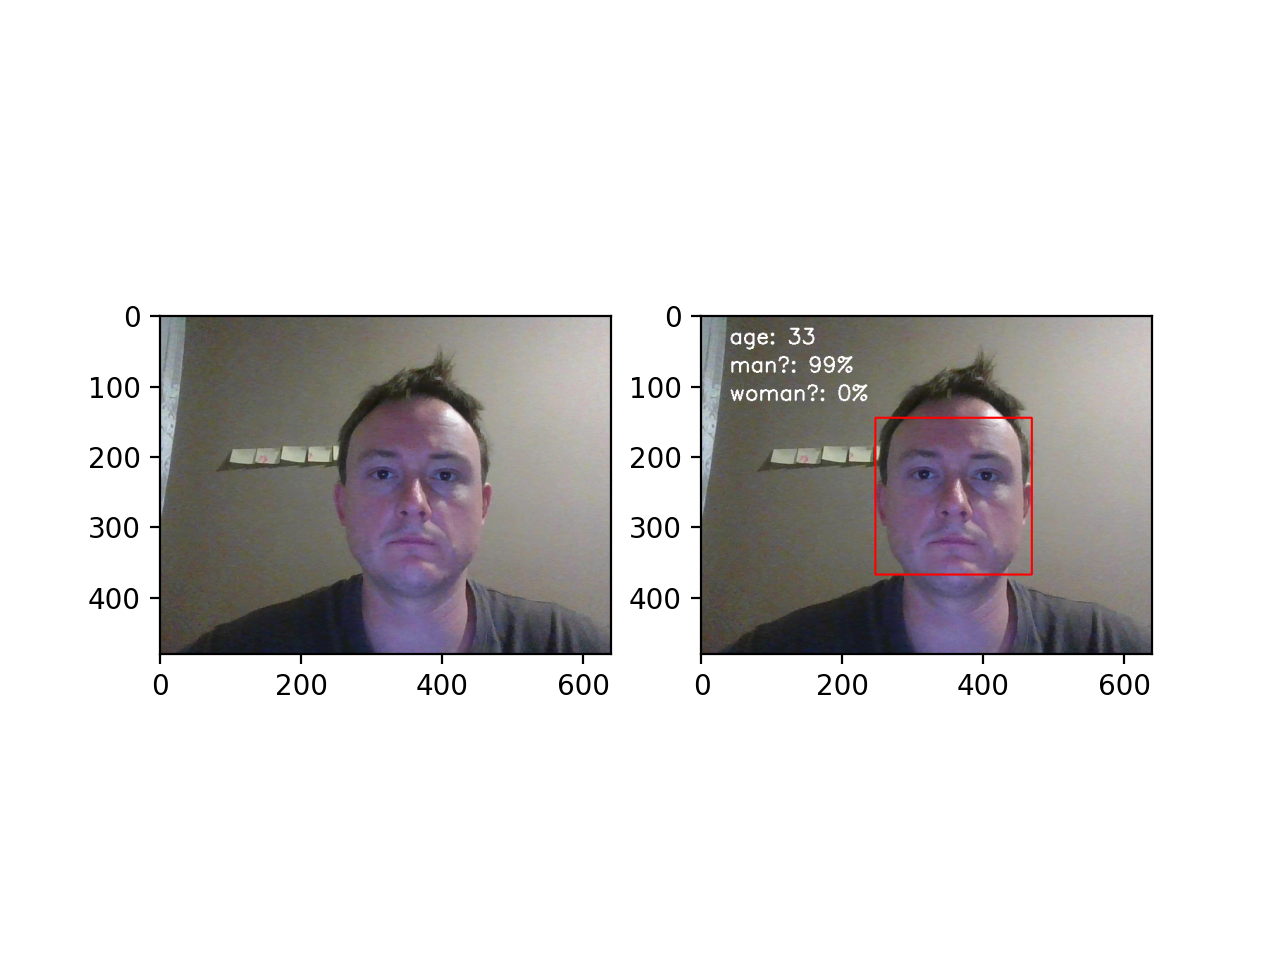

In [10]:
import logging as log

#create two subplots
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

#create two image plots
frame = grab_frame()
im1 = ax1.imshow(frame)
im2 = ax2.imshow(frame)
font = cv2.FONT_HERSHEY_SIMPLEX

def update(i):
    frame = grab_frame()
    imin = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    imout = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    images = np.ndarray(shape=(nn, nc, nh, nw))
    
    for (x,y,w,h) in faces:
        imout = cv2.rectangle(imout,(x,y), (x+w,y+h), (255,0,0), 2)
        face = frame[y:y+h, x:x+w]
        
        face_resized = cv2.resize(face, (nw, nh))
        face_resized = face_resized.transpose((2, 0, 1))
        
        images[0] = face_resized
        
        data = {}
        data["data"] = images
        
        res = exec_net.infer(inputs=data)
        log.debug(res)
        cv2.putText(imout,"age: " + str(int(res["age_conv3"][0][0][0][0] * 100)),(40,40), font, 1,(255,255,255),2)
        cv2.putText(imout,"man?: " + str(int(res["prob"][0][1][0][0] * 100)) + "%",(40,80), font, 1,(255,255,255),2)
        cv2.putText(imout,"woman?: " + str(int(res["prob"][0][0][0][0] * 100)) + "%",(40,120), font, 1,(255,255,255),2)
        
    
    im1.set_data(imin)
    im2.set_data(imout)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap1.release()

ani = FuncAnimation(plt.gcf(), update, interval=50)
plt.show()